## Over / Under with Nested Models
- ### Last time, we explored the calibration of the individual team runs scored models
- ### We observed some degree of mis-calibration: over-predicting the probability of low runs scored, under-predicting the probability of high runs scored
- ### However, these discrepancies did not seem large enough to explain the high degree of miscalibration in the overall model
- ### Concluded that the independence assumption must be flawed
- ### In this notebook, we use *nested modeling* to predict the total runs scored


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
stb.__version__

'0.4.3'

In [3]:
# How unlikely is it that we would get 197 (or fewer) successes in 344 trials if the success probability is .7?
.7*(197+147)

240.79999999999998

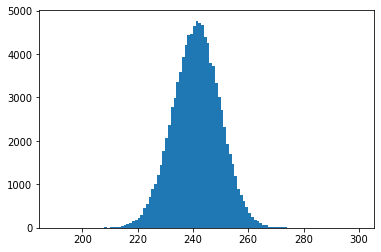

In [4]:
plt.hist(np.random.binomial(n=(197+147), p=.7, size=100000), bins=np.linspace(190,300,111));

In [5]:
df=pd.read_csv('df_bp9.csv')
df_runs=pd.read_csv('df_runs_bp11.csv')

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (13,14,15,19,85,87,159,206) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.over_under_line.max()

15.0

In [7]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)

### Nested Modeling
- Idea: use the outputs of one model as the inputs to a second model
- Want to use the predicted distributions (and the over / under line) to predict probability of over / under (rather than relying on the independence assumption)
- Problem: If we use our previous runs scored model and apply it to the training data, the predictions will be overconfident (or otherwise weird)
- Need predicted distributions on the training set that are "credible" (i.e. predictions from a model that did not see that point in the training set)
- We will use cross-validation to get these values.
- We will create folds based on time.

In [8]:
fold_dict = {}
fold_dict[1980]=-1
for i in range(1981,2018,5):
    fold_dict[i]=0
for i in range(1982,2018,5):
    fold_dict[i]=1
for i in range(1983,2018,5):
    fold_dict[i]=2
for i in range(1984,2018,5):
    fold_dict[i]=3
for i in range(1985,2018,5):
    fold_dict[i]=4
fold_dict[2018] = 5 # validation set
for i in range(2018,2023):
    fold_dict[i]=6 # test set
df_runs['foldnum1'] = df_runs.season.apply(lambda x: fold_dict[x])

    

In [9]:
pd.crosstab(df_runs.season, df_runs.foldnum1)

foldnum1,-1,0,1,2,3,4,6
season,,,,,,,
1980,4210,0,0,0,0,0,0
1981,0,2788,0,0,0,0,0
1982,0,0,4212,0,0,0,0
1983,0,0,0,4216,0,0,0
1984,0,0,0,0,4210,0,0
1985,0,0,0,0,0,4206,0
1986,0,4204,0,0,0,0,0
1987,0,0,4208,0,0,0,0
1988,0,0,0,4200,0,0,0


In [10]:
df_runs.shape

(192496, 159)

In [11]:
df_runs.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
0,1980,19800409,0,198004090,SEA,TOR,AL,AL,0.0,NaN,SEA02,N,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258957,0.244999,0.261081,0.248690,0.316389,0.299753,0.318195,0.303498,0.391599,0.366607,0.393452,0.371455,0.707988,0.666360,0.711647,0.674953,0.302610,0.283802,0.301660,0.285333,0.103902,0.099765,0.103370,0.099810,0.247605,0.241513,0.247225,0.241943,0.302829,0.293223,0.301952,0.293652,0.357380,0.344445,0.356761,0.345529,0.660209,0.637667,0.658713,0.639181,0.277352,0.272526,0.275707,0.271654,0.101148,0.107454,0.100206,0.105801,0.236959,0.232164,0.235594,0.231540,0.293375,0.284567,0.291567,0.284053,0.341385,0.330441,0.339080,0.329750,0.634760,0.615009,0.630646,0.613803,0.271778,0.267889,0.269267,0.266116,0.101146,0.108100,0.099922,0.106111,0.207199,0.203860,0.206608,0.203750,0.259931,0.254701,0.258950,0.254479,0.296881,0.288656,0.295494,0.288449,0.556812,0.543357,0.554444,0.542928,0.243524,0.242021,0.241553,0.240432,0.092185,0.098451,0.091244,0.096804,5.692771,1.572289,0.104418,0.349398,0.502008,5.186747,1.152610,3.857143,1.357945,0.115165,0.321551,0.434436,4.040128,0.956670,4.644315,1.460641,0.098187,0.336354,0.459215,4.723032,1.087613,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1,8,-1
1,1980,19800409,0,198004090,CIN,ATL,NL,NL,0.0,NaN,CIN08,D,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291169,0.266224,0.291499,0.269692,0.358840,0.326376,0.359266,0.3308

In [12]:
df_runs.iloc[96248:96253,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
96248,1980,19800409,0,198004090,SEA,TOR,AL,AL,0.0,NaN,SEA02,N,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.251190,0.243650,0.252654,0.245930,0.311006,0.303800,0.313585,0.307045,0.373838,0.367486,0.376542,0.370734,0.684844,0.671286,0.690127,0.677779,0.322135,0.332496,0.323723,0.332614,0.130839,0.140233,0.129892,0.138184,0.246034,0.226845,0.248341,0.231366,0.305095,0.283048,0.308265,0.288711,0.373292,0.345889,0.376522,0.352287,0.678387,0.628937,0.684787,0.640998,0.307383,0.293970,0.309149,0.297269,0.112892,0.111459,0.112663,0.111435,0.236335,0.213848,0.239270,0.219355,0.295922,0.268528,0.300137,0.275815,0.355710,0.322702,0.359510,0.330328,0.651631,0.591231,0.659647,0.606143,0.289422,0.266866,0.291998,0.272058,0.101515,0.095380,0.101639,0.096271,0.233920,0.209675,0.237107,0.215633,0.293435,0.263371,0.297808,0.271140,0.338192,0.303631,0.342667,0.312063,0.631627,0.567002,0.640475,0.583202,0.272961,0.247077,0.276019,0.253126,0.100074,0.091336,0.100556,0.092881,3.841004,1.418410,0.131579,0.330409,0.418129,3.941423,0.918129,3.616071,1.352679,0.129237,0.320975,0.418432,3.897321,0.924788,4.101266,1.465190,0.123188,0.335507,0.434058,4.348101,0.995652,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,0,6,-1
96249,1980,19800409,0,198004090,CIN,ATL,NL,NL,0.0,NaN,CIN08,D,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263363,0.258648,0.265619,0.261284,0.317190,0.308462,0.31899

In [13]:
df_train = df_runs[(df_runs.season>1980) & (df_runs.season<=2017)]
df_valid = df_runs[(df_runs.season>=2018) & (df_runs.season<=2018)]
df_test = df_runs[df_runs.season>=2019]

df_test_game = df[df.season>=2019]

In [14]:
df_train.shape, df_valid.shape, df_test.shape

((167074, 159), (4854, 159), (16358, 159))

In [15]:
df_train.shape[0] /2,  df_valid.shape[0]/2, df_test.shape[0]/2

(83537.0, 2427.0, 8179.0)

In [16]:
df_train.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
2105,1981,19810408,0,198104080,CIN,PHI,NL,NL,0.0,NaN,CIN08,D,3,0.260274,0.317690,0.360078,0.677768,23.0,26.0,13.0,0.261900,0.327182,0.385373,0.712555,106.0,156.0,43.0,0.261491,0.245399,0.262936,0.248749,0.325573,0.315040,0.326352,0.317081,0.387758,0.363193,0.390081,0.368411,0.713332,0.678232,0.716433,0.685492,0.317936,0.339020,0.318260,0.336634,0.116678,0.141321,0.116880,0.138372,0.271826,0.256997,0.273149,0.260076,0.341794,0.324855,0.342767,0.327886,0.407049,0.385581,0.408312,0.389449,0.748842,0.710436,0.751079,0.717335,0.347727,0.363660,0.347562,0.361487,0.130207,0.155845,0.130373,0.152737,0.274354,0.259524,0.275138,0.262116,0.345153,0.329310,0.345806,0.331913,0.417573,0.393889,0.417920,0.397212,0.762725,0.723199,0.763726,0.729124,0.355185,0.368712,0.354974,0.366802,0.129753,0.153798,0.129913,0.150887,0.258644,0.246661,0.261260,0.250546,0.327018,0.314656,0.329858,0.318790,0.396584,0.376554,0.399446,0.381683,0.723602,0.691210,0.729304,0.700473,0.339735,0.354625,0.341308,0.354154,0.123324,0.147039,0.124119,0.144744,2.678571,1.154762,0.218659,0.282799,0.408163,2.607143,0.638484,2.284863,1.097735,0.238516,0.271201,0.366608,2.013111,0.497350,2.884413,1.122592,0.220595,0.276174,0.389918,2.507881,0.616975,1.110000,0.195122,0.300813,0.414634,1.203947,0.145780,0.312020,0.401535,1.250404,0.153359,0.326996,0.422053,1,3,0
2106,1981,19810409,0,198104090,DET,TOR,AL,AL,0.0,NaN,DET04,D,6,0.260077,0.345501,

In [17]:
df_train.iloc[83537:83537+5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
98353,1981,19810408,0,198104080,CIN,PHI,NL,NL,0.0,NaN,CIN08,D,2,0.254563,0.312666,0.368876,0.681542,16.0,25.0,15.0,0.269689,0.326226,0.399644,0.725870,136.0,140.0,62.0,0.261043,0.255650,0.260670,0.255998,0.318003,0.307361,0.317593,0.308342,0.378524,0.361466,0.379273,0.364310,0.696527,0.668826,0.696866,0.672652,0.277414,0.272653,0.278979,0.274672,0.092864,0.105866,0.093477,0.104767,0.275035,0.268044,0.275708,0.269541,0.329882,0.318954,0.330382,0.320794,0.401675,0.382858,0.402780,0.386246,0.731557,0.701812,0.733162,0.707040,0.287846,0.282136,0.288360,0.283325,0.097280,0.107817,0.097548,0.106721,0.276629,0.273088,0.277966,0.274745,0.332393,0.325307,0.333872,0.327543,0.412190,0.399544,0.414119,0.402892,0.744583,0.724851,0.747991,0.730435,0.300790,0.296965,0.301442,0.298040,0.100459,0.109613,0.100268,0.108277,0.277738,0.270532,0.278523,0.272156,0.340170,0.328801,0.341207,0.331181,0.418327,0.400837,0.419152,0.403804,0.758497,0.729638,0.760359,0.734985,0.315862,0.312831,0.316345,0.313653,0.102595,0.114569,0.102652,0.113099,2.050633,0.987342,0.177419,0.251613,0.364516,2.721519,0.693548,3.452586,1.163793,0.144681,0.287234,0.428723,4.000000,0.987234,3.122807,1.146199,0.166747,0.281744,0.403450,3.374269,0.829420,0.916667,0.129412,0.258824,0.282353,1.334646,0.171779,0.346626,0.411043,1.163666,0.163424,0.307393,0.383917,0,2,0
98354,1981,19810409,0,198104090,DET,TOR,AL,AL,0.0,NaN,DET04,D,2,0.245387,0.30383

In [18]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [19]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

In [20]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

Now, we will do "nested" prediction to create the run distribution values

In [21]:
run_dist_train = np.zeros((df_train.shape[0], 17))

In [22]:
# Loop to get cross-validated predictions on the training set
model_list = []
preds_list = []
for fn in range(5):
    tr_mask = df_train.foldnum1!=fn
    te_mask = df_train.foldnum1==fn
    X_tr = df_train.loc[tr_mask,feat_set]
    X_te = df_train.loc[te_mask,feat_set]
    y_tr = df_train[target][tr_mask]
    y_te = df_train[target][te_mask]
    model_list.append(stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2))
    model_list[fn].fit(X_tr, y_tr, eval_set=(X_te, y_te), early_stop_past_steps=5, eval_freq=10)
    run_dist_train[te_mask,:] = model_list[fn].predict_distributions(X_te).probmat

i=0, eval_set_loss = 2.4528841134571837
i=10, eval_set_loss = 2.449094338527277
i=20, eval_set_loss = 2.4461952826706277
i=30, eval_set_loss = 2.443961579060978
i=40, eval_set_loss = 2.4422760033038178
i=50, eval_set_loss = 2.440941145651821
i=60, eval_set_loss = 2.439965072413279
i=70, eval_set_loss = 2.4391145522198228
i=80, eval_set_loss = 2.4382849301342944
i=90, eval_set_loss = 2.4376679113296515
i=100, eval_set_loss = 2.43711749310981
i=110, eval_set_loss = 2.436742198982637
i=120, eval_set_loss = 2.436392034809173
i=130, eval_set_loss = 2.436128287414446
i=140, eval_set_loss = 2.4358899890519337
i=150, eval_set_loss = 2.435721475810518
i=160, eval_set_loss = 2.43556011966732
i=170, eval_set_loss = 2.4354569145277476
i=180, eval_set_loss = 2.4354026299784977
i=190, eval_set_loss = 2.4353268756015067
i=200, eval_set_loss = 2.4352438732744957
i=210, eval_set_loss = 2.4351889579385535
i=220, eval_set_loss = 2.435165116203904
i=230, eval_set_loss = 2.435150846927533
i=240, eval_set_l

In [25]:
# Redo previous approach to get predictions on valid, test sets
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.450034997383088
i=10, eval_set_loss = 2.4469491083469337
i=20, eval_set_loss = 2.4447409099946102
i=30, eval_set_loss = 2.4432593119610653
i=40, eval_set_loss = 2.442014353173544
i=50, eval_set_loss = 2.44117378766591
i=60, eval_set_loss = 2.4405556046820203
i=70, eval_set_loss = 2.4400400739469985
i=80, eval_set_loss = 2.4396878636685977
i=90, eval_set_loss = 2.439399737212208
i=100, eval_set_loss = 2.4391684794361757
i=110, eval_set_loss = 2.4387842721105155
i=120, eval_set_loss = 2.4387764086697468
i=130, eval_set_loss = 2.438684543031254
i=140, eval_set_loss = 2.438652351061534
i=150, eval_set_loss = 2.438578404155921
i=160, eval_set_loss = 2.4384263077077963
i=170, eval_set_loss = 2.4383620766454634
i=180, eval_set_loss = 2.4383873111362235
i=190, eval_set_loss = 2.438468515631098
i=200, eval_set_loss = 2.438529318705761
i=210, eval_set_loss = 2.4385818923039015
i=220, eval_set_loss = 2.4388097869058134
Stopping early: low pt was 5 steps ago


In [24]:
run_dist_valid = cr1.predict_distributions(X_valid).probmat
run_dist_test = cr1.predict_distributions(X_test).probmat

In [26]:
cr1.predict_distributions(X_test).log_loss(y_test)

2.4499763709777955

In [27]:
run_cdf_train = np.cumsum(run_dist_train, axis=1)[:,:-1]
run_cdf_valid = np.cumsum(run_dist_valid, axis=1)[:,:-1]
run_cdf_test = np.cumsum(run_dist_test, axis=1)[:,:-1]

In [28]:
result_probs = np.array([run_dist_train[i,y_train[i]] for i in range(len(y_train))])

In [29]:
-np.mean(np.log(result_probs))

2.431763776878976

In [30]:
run_cdf_train1 = run_cdf_train[:83537,:]
run_cdf_train2 = run_cdf_train[83537:,:]
run_cdf_valid1 = run_cdf_valid[:2427,:]
run_cdf_valid2 = run_cdf_valid[2427:,:]
run_cdf_test1 = run_cdf_test[:8179,:]
run_cdf_test2 = run_cdf_test[8179:,:]

run_train_team1 = y_train[:83537]
run_train_team2 = y_train[83537:]
run_valid_team1 = y_valid[:2427]
run_valid_team2 = y_valid[2427:]
run_test_team1 = y_test[:8179]
run_test_team2 = y_test[8179:]

run_total_train = run_train_team1 + run_train_team2
run_total_valid = run_valid_team1 + run_valid_team2
run_total_test = run_test_team1 + run_test_team2

run_total_train = np.minimum(run_total_train, 16)
run_total_valid = np.minimum(run_total_valid, 16)
run_total_test = np.minimum(run_total_test, 16)

base_cols = ['rd'+str(i) for i in range(16)]
cn1 = [cn+'_h' for cn in base_cols]
cn2 = [cn+'_v' for cn in base_cols]
cn_list = cn1+cn2

In [32]:
X_train_nested = pd.DataFrame(np.hstack((run_cdf_train1, run_cdf_train2)))
X_valid_nested = pd.DataFrame(np.hstack((run_cdf_valid1, run_cdf_valid2)))
X_test_nested = pd.DataFrame(np.hstack((run_cdf_test1, run_cdf_test2)))

X_train_nested.columns = cn1+cn2
X_valid_nested.columns = cn1+cn2
X_test_nested.columns = cn1+cn2

In [33]:
run_cdf_train1.shape, run_cdf_train2.shape, X_train_nested.shape

((83537, 16), (83537, 16), (83537, 32))

In [34]:
X_train_nested.sample(10)

,rd0_h,rd1_h,rd2_h,rd3_h,rd4_h,rd5_h,rd6_h,rd7_h,rd8_h,rd9_h,rd10_h,rd11_h,rd12_h,rd13_h,rd14_h,rd15_h,rd0_v,rd1_v,rd2_v,rd3_v,rd4_v,rd5_v,rd6_v,rd7_v,rd8_v,rd9_v,rd10_v,rd11_v,rd12_v,rd13_v,rd14_v,rd15_v
76588,0.062236,0.172332,0.312790,0.464289,0.607495,0.724257,0.813854,0.879469,0.923013,0.952529,0.970942,0.982562,0.989936,0.994153,0.996638,0.998191,0.092359,0.239063,0.410814,0.563901,0.691326,0.789237,0.861052,0.912247,0.943480,0.965471,0.979195,0.987148,0.992591,0.995558,0.997384,0.998622
16420,0.049672,0.142305,0.269311,0.413306,0.553288,0.675567,0.774425,0.848100,0.899012,0.934894,0.958384,0.973515,0.984231,0.990506,0.994177,0.996668,0.071634,0.189422,0.341017,0.490348,0.619259,0.732481,0.819322,0.880193,0.918516,0.946073,0.966589,0.978376,0.987559,0.992593,0.995673,0.997901
32471,0.046914,0.138288,0.260681,0.401802,0.541935,0.662964,0.758467,0.835768,0.892118,0.928618,0.955215,0.972001,0.981947,0.988434,0.992180,0.995643,0.049820,0.152641,0.276497,0.418546,0.550631,0.662740,0.755130,0.827706,0.884112,0.921058,0.949023,0.967831,0.979824,0.987512,0.992379,0.995384
63011,0.027601,0.085636,0.169180,0.276405,0.393237,0.511288,0.627804,0.721208,0.797980,0.857587,0.901748,0.934597,0.956271,0.972243,0.981660,0.987657,0.063333,0.179070,0.319259,0.464652,0.593445,0.702243,0.789225,0.854239,0.899427,0.930668,0.955062,0.970364,0.982212,0.989402,0.993719,0.996369
18404,0.095656,0.236851,0.407216,0.558671,0.685571,0.782619,0.855532,0.907443,0.941529,0.963631,0.977677,0.986637,0.992440,0.995516,0.997345,0.998465,0.059484,0.171519,0.313859,0.459238,0.599907,0.717747,0.809828,0.877322,0.919543,0.948960,0.968323,0.980489,0.988365,0.993112,0.995857,0.997655
79135,0.053878,0.149091,0.281194,0.430706,0.570568,0.690435,0.788511,0.855497,0.903178,0.935171,0.960143,0.975902,0.986124,0.991307,0.994970,0.996924,0.065641,0.182305,0.325025,0.468862,0.597799,0.706716,0.793937,0.857757,0.903877,0.936929,0.961091,0.976496,0.986282,0.991850,0.995209,0.997125
56987,0.051622,0.145558,0.271984,0.412804,0.550698,0.673808,0.772032,0.845409,0.897887,0.933943,0.957613,0.974135,0.984682,0.990982,0.994688,0.996891,0.051929,0.148738,0.269237,0.406061,0.535054,0.648074,0.744245,0.819632,0.875353,0.914589,0.944283,0.964306,0.978394,0.987260,0.992597,0.995748
13317,0.043814,0.129070,0.243348,0.378482,0.513048,0.634665,0.738186,0.818355,0.876194,0.917185,0.946135,0.965721,0.978855,0.987236,0.992225,0.995246,0.038621,0.113316,0.213079,0.332716,0.457994,0.572651,0.680060,0.769488,0.836554,0.886085,0.924049,0.950029,0.967601,0.980143,0.987614,0.992766
63042,0.038426,0.115104,0.219233,0.342192,0.466785,0.589882,0.700261,0.782903,0.848013,0.894868,0.930093,0.953436,0.970399,0.981327,0.988212,0.992346,0.041982,0.123194,0.228690,0.355350,0.485607,0.600443,0.706618,0.789809,0.849912,0.896201,0.930040,0.954361,0.971744,0.982564,0.989403,0.993910
29401,0.042589,0.123200,0.231986,0.363131,0.497306,0.621052,0.726321,0.812014,0.875389,0.917910,0.947001,0.966513,0.979446,0.987653,0.992155,0.995407,0.132097,0.289241,0.469912,0.617458,0.728312,0.810452,0.872697,0.917275,0.946566,0.966148,0.978828,0.987316,0.992541,0.995690,0.997351,0.998408


In [35]:
cr_final = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr_final.fit(X_train_nested, run_total_train, eval_set=(X_valid_nested, run_total_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.6834024838525057
i=10, eval_set_loss = 2.681623019280149
i=20, eval_set_loss = 2.680324811493553
i=30, eval_set_loss = 2.679557420472623
i=40, eval_set_loss = 2.679159837069661
i=50, eval_set_loss = 2.67914096391295
i=60, eval_set_loss = 2.679232922286281
i=70, eval_set_loss = 2.6792086384932614
i=80, eval_set_loss = 2.6791807172794737
i=90, eval_set_loss = 2.6791752294894233
i=100, eval_set_loss = 2.679223013100211
Stopping early: low pt was 5 steps ago


In [36]:
final_test_dists = cr_final.predict_distributions(X_test_nested)

In [37]:
final_test_dists.log_loss(run_total_test)

2.665385950387393

In [38]:
start_test_dists = cr_final.predict_distributions(X_test_nested, num_trees_to_use=1)
start_test_dists.log_loss(run_total_test)

2.6721454881782347

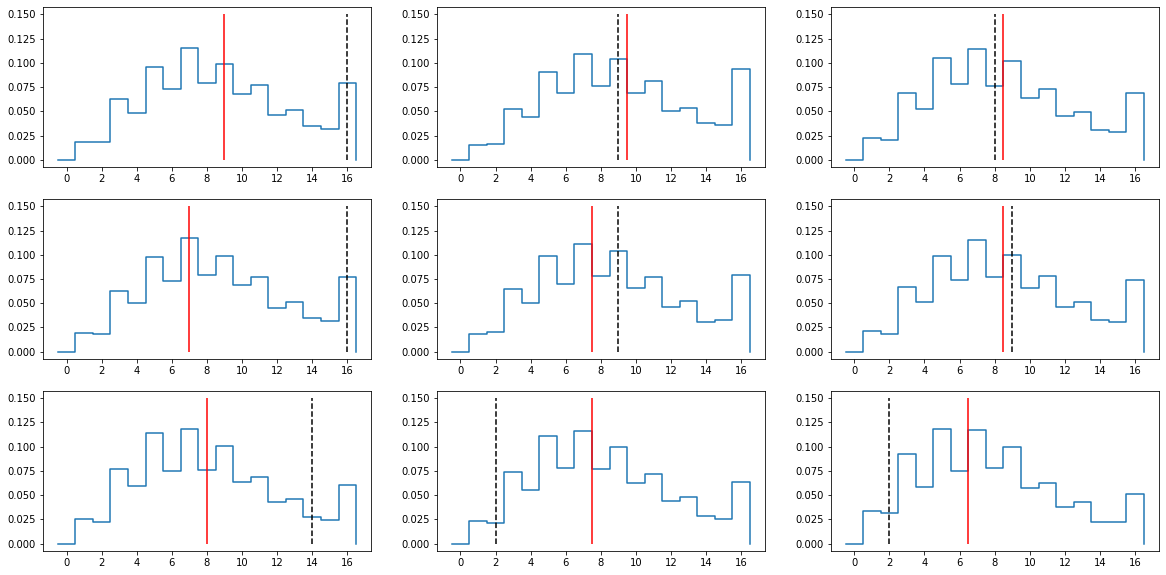

In [39]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    final_test_dists[i].plot_density()
    plt.vlines(run_total_test[i],ymin=0,ymax=.15, color='k', linestyle='--')
    plt.vlines(df_test_game.over_under_line.iloc[i],ymin=0,ymax=.15, color='red')
    plt.xticks(np.linspace(0,16,9))

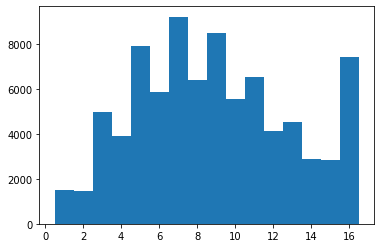

In [40]:
plt.hist(run_total_train, bins=np.linspace(0.5, 16.5, 17));

In [41]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(df_test_game.over_under_line.iloc[i]))]) 
                    for i in range(len(run_total_test))])

In [42]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(df_test_game.over_under_line.iloc[i]+1)):]) 
                    for i in range(len(run_total_test))])

In [43]:
push_probs_test = 1-under_probs_test-over_probs_test

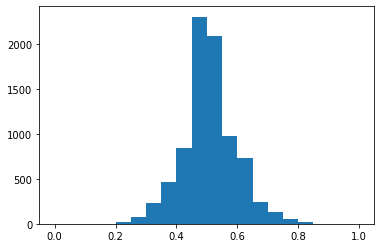

In [44]:
plt.hist(under_probs_test, bins=np.linspace(0,1,21));

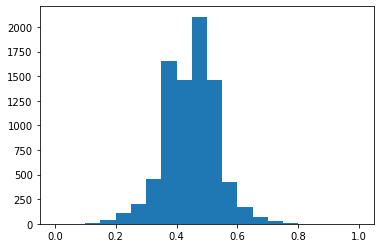

In [45]:
plt.hist(over_probs_test, bins=np.linspace(0,1,21));

## Examine Calibration of Over/Under Predictions

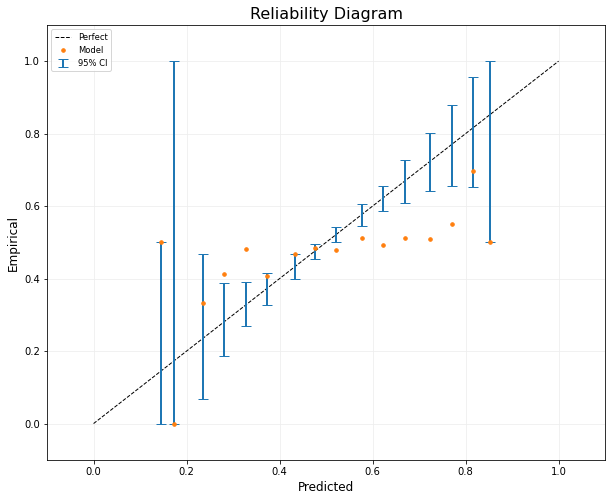

In [46]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='U').astype(int), under_probs_test, np.linspace(0,1,21));
#plt.ylim([.3,.7])

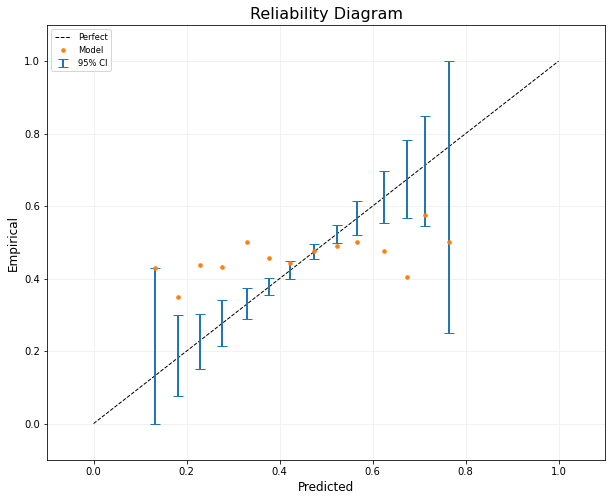

In [47]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='O').astype(int), over_probs_test, np.linspace(0,1,21));


(0.0, 0.2)

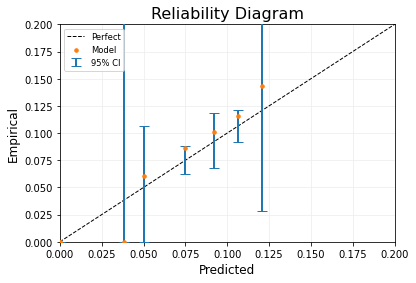

In [48]:
mli.plot_reliability_diagram((df_test_game.over_under_result=='P').astype(int), push_probs_test, np.linspace(0,1,51));
plt.xlim([0,.2])
plt.ylim([0,.2])

In [49]:
def evaluate_edge_probs(oupmat, edge, test_df_w_ouline):
    bet_under = (oupmat[:,1]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    bet_over = (oupmat[:,0]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    num_cases_under = np.sum(bet_under)
    num_cases_over = np.sum(bet_over)
    num_cases_total = num_cases_under + num_cases_over
    num_under_correct = (test_df_w_ouline.loc[bet_under,'over_under_result']=='U').sum()
    num_under_push = (test_df_w_ouline.loc[bet_under,'over_under_result']=='P').sum()
    num_over_correct = (test_df_w_ouline.loc[bet_over,'over_under_result']=='O').sum()
    num_over_push = (test_df_w_ouline.loc[bet_over,'over_under_result']=='P').sum()
    num_correct = num_under_correct + num_over_correct
    num_pushes = num_under_push + num_over_push
    num_incorrect = num_cases_total -num_correct - num_pushes
    pct_correct = num_correct / num_cases_total
    pct_pushes = num_pushes / num_cases_total
    pct_incorrect = num_incorrect / num_cases_total
    pct_under_correct = num_under_correct/num_cases_under
    pct_under_push = num_under_push/num_cases_under
    pct_over_correct = num_over_correct/num_cases_over
    pct_over_push = num_over_push/num_cases_over
    print(f'\nThere were {num_cases_total} games that met criteria of edge > {edge} ({num_cases_under} unders and {num_cases_over} overs)')
    print(f'Of them {num_correct} ({np.round(pct_correct,3)}) were correct (winning bets), ({num_under_correct} unders and {num_over_correct} overs) ')
    print(f'and {num_pushes} ({np.round(pct_pushes,3)}) were Pushes ({num_under_push} unders and {num_over_push} overs)')
    print(f'and {num_incorrect} ({np.round(pct_incorrect,3)}) were incorrect (losing bets))')
    winning_edge_m110 = pct_correct*1 + pct_incorrect*(-1.1)
    win_total_m110 = num_correct*1 + num_incorrect*(-1.1)
    print(f'Betting the Under at a line of -110, your profit would have been {np.round(winning_edge_m110,4)} per bet')
    print(f'\t for a total profit of {np.round(win_total_m110,2)} across all {num_cases_total} bets')
    print('\n')
 

In [50]:
oup_probs = np.vstack((over_probs_test, under_probs_test, push_probs_test)).T

In [51]:
for i in np.linspace(.25, .05,5):
    print(f'threshold = {i}')
    evaluate_edge_probs(oup_probs, i, df_test_game)


threshold = 0.25

There were 141 games that met criteria of edge > 0.25 (130 unders and 11 overs)
Of them 81 (0.574) were correct (winning bets), (75 unders and 6 overs) 
and 6 (0.043) were Pushes (4 unders and 2 overs)
and 54 (0.383) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.1532 per bet
	 for a total profit of 21.6 across all 141 bets


threshold = 0.2

There were 365 games that met criteria of edge > 0.2 (302 unders and 63 overs)
Of them 197 (0.54) were correct (winning bets), (163 unders and 34 overs) 
and 17 (0.047) were Pushes (12 unders and 5 overs)
and 151 (0.414) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.0847 per bet
	 for a total profit of 30.9 across all 365 bets


threshold = 0.15

There were 792 games that met criteria of edge > 0.15 (625 unders and 167 overs)
Of them 396 (0.5) were correct (winning bets), (318 unders and 78 overs) 
and 31 (0.039) were Pushes (24 u

## Calibration with respect to fixed values

In [52]:
df_test_game.over_under_line.mean()

8.656926274605697

In [53]:
line=8.5

In [54]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line))]) 
                    for i in range(len(run_total_test))])

In [55]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line))+1:]) 
                    for i in range(len(run_total_test))])

In [56]:
push_probs_test = 1-under_probs_test-over_probs_test

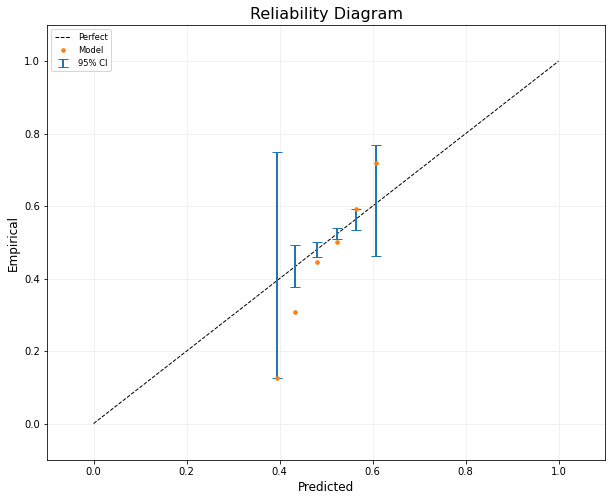

In [57]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,21));


(0.1, 0.9)

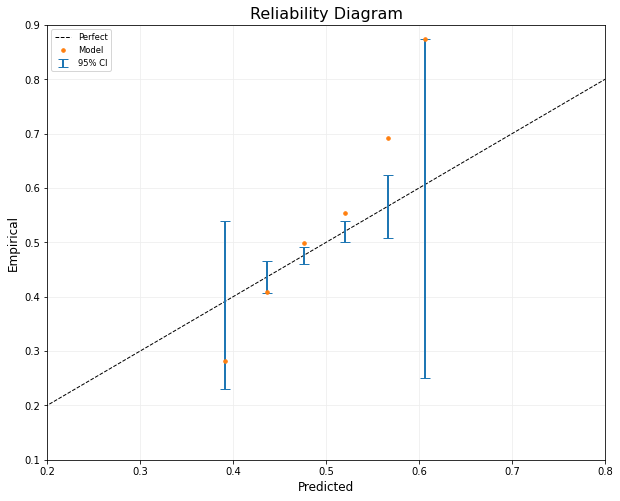

In [58]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,21));
plt.xlim([.2,.8])
plt.ylim([.1,.9])

## Calibration with respect to randomly chosen line

(array([418., 385., 409., 404., 369., 368., 410., 380., 395., 390., 412.,
        394., 392., 366., 389., 394., 353., 380., 378., 397., 396.]),
 array([ 4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
         9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
        13.75, 14.25, 14.75, 15.25]),
 <BarContainer object of 21 artists>)

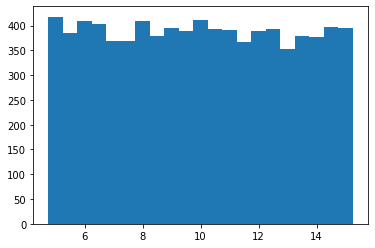

In [59]:
line = np.random.randint(10,31,size=len(run_total_test))/2
plt.hist(line, bins=np.linspace(4.75,15.25,22))

In [60]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line[i]))]) 
                    for i in range(len(run_total_test))])

In [61]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line[i]))+1:]) 
                    for i in range(len(run_total_test))])

In [62]:
push_probs_test = 1-under_probs_test-over_probs_test

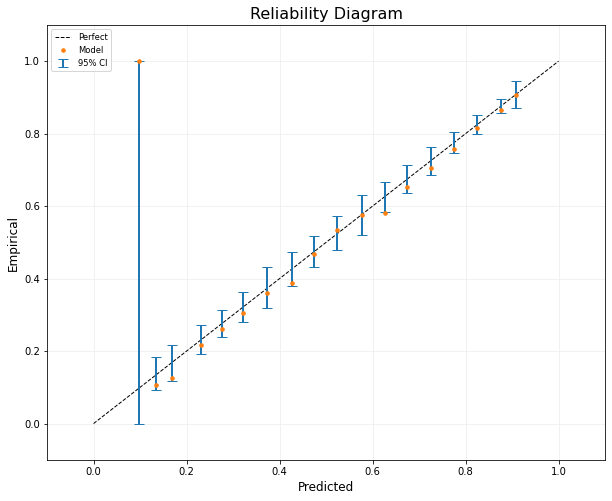

In [63]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,21));


(0.1, 0.9)

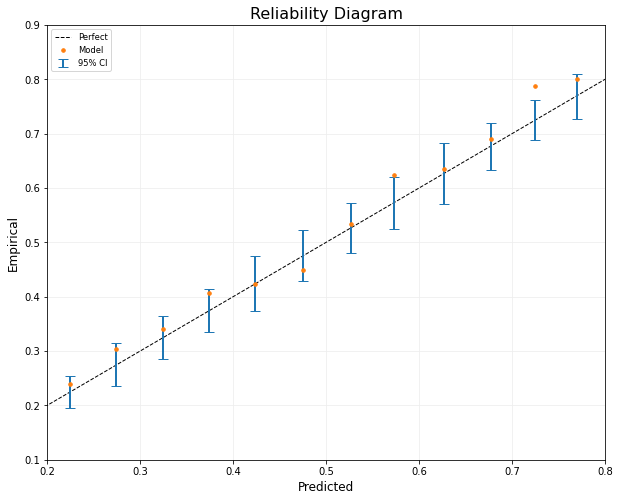

In [64]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,21));
plt.xlim([.2,.8])
plt.ylim([.1,.9])

## Conclusions
- ### The information inherent in the Vegas line is likely the primary source of the overall miscalibration
- ### Model tends to over-predict low scores and under-predict high scores.
    - #### This is seen in both the individual team runs scored model and the combined model
- ### Independence assumption seems less of a problem than before (could do more direct comparison)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## Next Steps
- ### Could try to dive deeper into the causes / solutions for the overprediction of low runs scored
    - #### Might just be model drift
    - #### Calibration / Conformal Prediction techniques will only help if there is a "good" data set to calibrate to
- ### Predict run differential using similar techniques
- ### Use all of the above to better predict the moneyline